In [34]:
import torch
from torch import nn
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt
import math
from dataloading import DataParser
from easydict import EasyDict
from ml import E2EModel, autoregress_sequense
from indicators import ZigZagNew
from backtest import MovingWindow
from tqdm import tqdm

DEVICE = torch.device("cpu")

In [35]:
DEVICE

device(type='cpu')

In [36]:
def compute_hold(p):
    hold = p if p[-1] - p[0] >= 0 else -p
    return hold - hold[0]

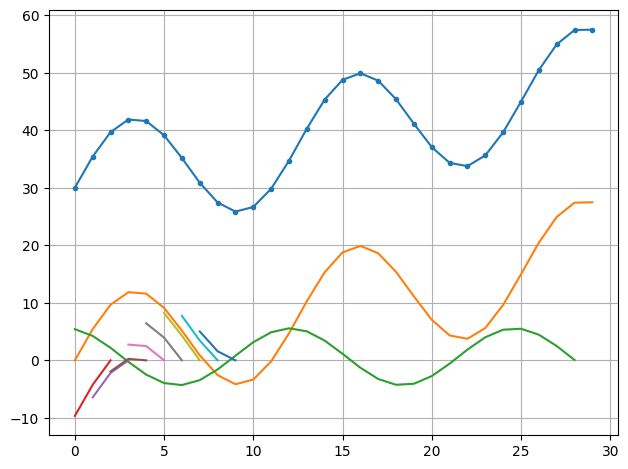

In [37]:
p = np.array([math.sin(x/2)+x/16 for x in range(30)]) + 3# + (np.random.random(L)-0.5)*2
p = torch.from_numpy(p.astype(np.float32))*10
dp = p[1:] - p[:-1]
hold = compute_hold(p)
plt.plot(p, ".-")
plt.plot(hold)
plt.plot(dp)

fsize = 3
features = []
for i in range(p.shape[0]):
    if i < fsize-1:
        features.append(torch.zeros(fsize))
    else:
        features.append(p[i-fsize+1:i+1] - p[i])

features = torch.vstack(features)
for i in range(fsize-1, 10):
    plt.plot(range(i-fsize+1, i+1), features[i].numpy())
plt.grid("on")
plt.tight_layout()

In [38]:
cfg = EasyDict({"data_type": "bybit", "period": "M60", "ticker": "BTCUSDT"})
data_pd, data_np = DataParser(cfg).load()
data_pd.head()

,Open,High,Low,Close,Volume,Id
Date,,,,,,
2017-08-17 07:00:00+00:00,4261.48,4313.62,4261.32,4308.83,46.0,0
2017-08-17 08:00:00+00:00,4308.83,4328.69,4291.37,4315.32,22.0,1
2017-08-17 09:00:00+00:00,4330.29,4345.45,4309.37,4324.35,6.0,2
2017-08-17 10:00:00+00:00,4316.62,4349.99,4287.41,4349.99,4.0,3
2017-08-17 11:00:00+00:00,4333.32,4377.85,4333.32,4360.69,0.0,4


In [39]:
wsize = 256
fsize = 3
zz = ZigZagNew(10)
mw = MovingWindow(data_np, wsize)
last_type = 0
p, features = [], []
for t in range(wsize-1, data_np.Close.shape[0]):
# for t in range(3000, data_np.Close.shape[0]): # best - 1500
    hist_window = mw(t)[0]
    zzx, zzp, zzt = zz.update(hist_window)
    zzx -= zzx[0]
    zzp -= zzp[-1]
    # zzx = 127 - zzx
    if zzt[-1] != last_type:
        last_type = zzt[-1]        
        p.append(hist_window.Close[-1])
        features.append(np.vstack([zzp[:fsize]]))
        if len(p) >= 50:
            break
        
features = torch.from_numpy(np.array(features).astype(np.float32))
p = torch.from_numpy(np.array(p).astype(np.float32)).to(DEVICE)
dp = p[1:] - p[:-1]
hold = compute_hold(p)
print(features.shape, dp.shape)

torch.Size([50, 1, 3]) torch.Size([49])


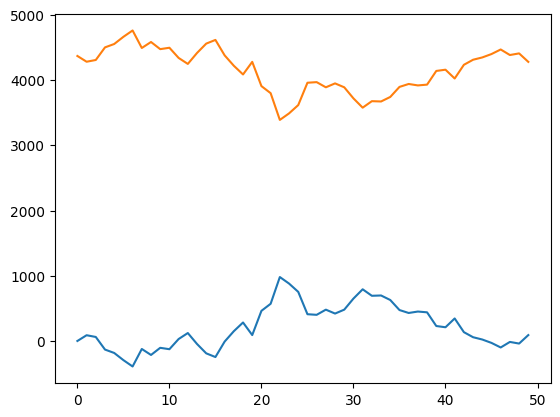

In [40]:
plt.plot(hold.cpu())
plt.plot(p.cpu())

In [41]:
# for i in range(fsize-1, 20):
#     plt.plot(range(i-fsize+1, i+1), features[i, 0].numpy())

In [42]:
model = E2EModel((1, fsize), 4)
model.to(DEVICE)

E2EModel(
  (fc_features_in): Linear(in_features=3, out_features=4, bias=True)
  (fc_hid): Linear(in_features=4, out_features=4, bias=True)
  (fc_out): Linear(in_features=4, out_features=1, bias=True)
  (norm_hid): InstanceNorm1d((4, 4), eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (norm_in): LayerNorm((1, 3), eps=1e-05, elementwise_affine=True)
  (norm_out): InstanceNorm1d(1, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (relu): ReLU()
  (tanh): Tanh()
)

In [43]:
num_epochs = 500
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        
# Training loop

for epoch in tqdm(list(range(num_epochs)), desc="Training"):
    optimizer.zero_grad()
    loss, _ = autoregress_sequense(model, p, dp, features, epoch=epoch, device=DEVICE)
    loss += hold[-1]
    loss.backward()
    optimizer.step()
    loss2print[0] = str(loss)
    # print(f"{epoch + 1:03}: epoch loss = {loss.item():9.3f}")
    # print("---------------------------")
    
model.eval()
output_seq, result_seq, fee_seq = autoregress_sequense(model, p, dp, features, output_sequense=True, device=DEVICE)

fig, ax1 = plt.subplots()
# ax1.plot(p - p[0], linewidth=3)
ax1.plot(result_seq.cumsum(0))
ax1.plot(fee_seq.cumsum(0))
ax1.plot(hold)
ax1.grid("on")
plt.tight_layout()
plt.grid("on")

ax2 = ax1.twinx()
ax2.bar(list(range(output_seq.shape[0])), height=output_seq, width=1, alpha=0.4)

Training:  22%|██▏       | 108/500 [00:01<00:06, 59.67it/s]


KeyboardInterrupt: 

In [ ]:
hold[-1], result_seq.sum(0)

(tensor(672.1399), 56261.99629801512)